# Learning objectives

In this Exercise, we will see : 

- How to interface transforms with data load
- The difference in performance between data loaders

## Installing dependencies

The following cell tries to import MONAI and will install its dependencies if needed in the NoteBook environment.

In [1]:
#@formatter:off
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.2.0"
#@formatter:on

### Verify your Configuration

Execute the following cell to check MONAI's configuration using MONAI's `print_config()`.

In [8]:
from monai.config import print_config

print_config()

MONAI version: 1.2.0
Numpy version: 1.26.1
Pytorch version: 2.1.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: C:\Work\Projects\2023_10_19_Formation_Medical_AI_EPITA\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.22.0
Pillow version: 10.1.0
Tensorboard version: 2.14.1
gdown version: 4.7.1
TorchVision version: 0.16.0+cpu
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.6
pandas version: 2.1.1
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.7.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies


### Creating Toy Data and Temp Directory for Examples

We'll create a temporary directory and populate it with a few example Nifti file-format images containing a random assortment of spheres.  We're also creating a matching segmentation pair that will be used later in the notebook.

In [3]:
from monai.data import create_test_image_3d
import tempfile
import nibabel as nib
import numpy as np

fn_keys = ("img", "seg")  # filename keys for image and seg files

root_dir = tempfile.mkdtemp()
print("Output temporary directory : ", root_dir)

filenames = []

for i in range(5):
    im, seg = create_test_image_3d(128, 128, 128, num_objs=16, rad_max=25)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

Output temporary directory :  C:\Users\Thibault\AppData\Local\Temp\tmpew65_7cc


### Creating a dataset from a transform

1. Separate images from labels in a list
2. Create a compose transform to load images
3. Use MONAI's Dataset class to wrap images and transform
4. Get the first image from the dataset and print it's shape

In [4]:
from monai.transforms import Compose, LoadImage, EnsureChannelFirst
from monai.data import Dataset

images = [fn["img"] for fn in filenames]

transform = Compose([fixMe])
ds = fixMe
img_tensor = ds[0]
print(fixMe)

torch.Size([1, 128, 128, 128]) -1


#### Creating an ArrayDataset

1. Separate images and labels in separate lists
2. Create a transform to load images
    1. Add a random spatial crop with the following settings `(128, 128, 128), random_size=False`
    2. Add random gaussian noise with the following settings `(.5, 1, 1)`
3. Create a transform to load labels
    1. Add a random spatial crop with the same settings as images
4. Use ArrayDataset to wrap images, image transform, labels, labels transforms
5. Get and plot the first image / label in the dataset and plot their content

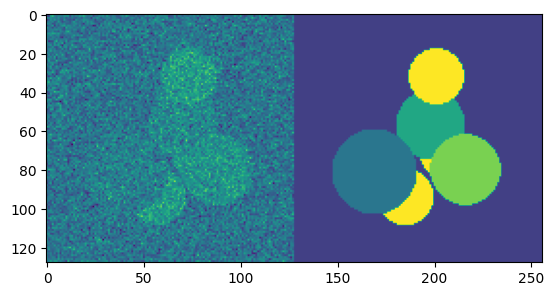

In [19]:
%matplotlib inline
from monai.transforms import RandSpatialCrop, RandGaussianNoise
from monai.data import ArrayDataset
from matplotlib import pyplot as plt

images = [fn["img"] for fn in filenames]
labels = [fn["seg"] for fn in filenames]

img_transform = Compose([fixMe])

seg_transform = Compose([fixMe])

ds = fixMe
im, seg = ds[0]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

### Dataset with Dictionary-based Transforms

1. Create a map transform which
    1. Loads the images and labels
    2. Ensures the channel first
    3. Applies a random gaussian noise to images only using the following setting `(.5, 1, 1)`
    4. Applies a random spatial crop to both images and segmentations using the following setting `(128, 128, 128), random_size=False`
2. Use the Dataset to wrap the images and transform
3. Get and display the first image and label


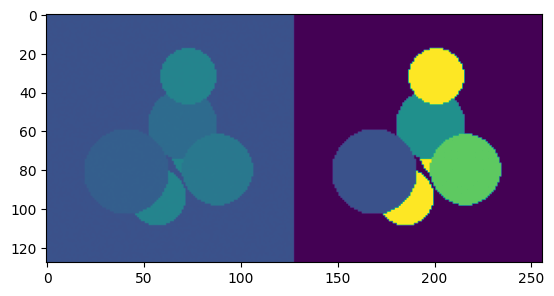

In [20]:
from monai.transforms import LoadImaged, EnsureChannelFirstd, RandGaussianNoised, RandSpatialCropd

trans = Compose([fixMe])

ds = fixMe
item = ds[0]
im, seg = item["img"], item["seg"]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

#### DataLoader

1. Wrap the previous dataset with a DataLoader
2. Use a batch size of 5 and as many workers
3. Get the first batch using monai.utils `first` 
4. Display the content of the images and segmentations in the batch

['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] torch.Size([5, 1, 128, 128, 128])


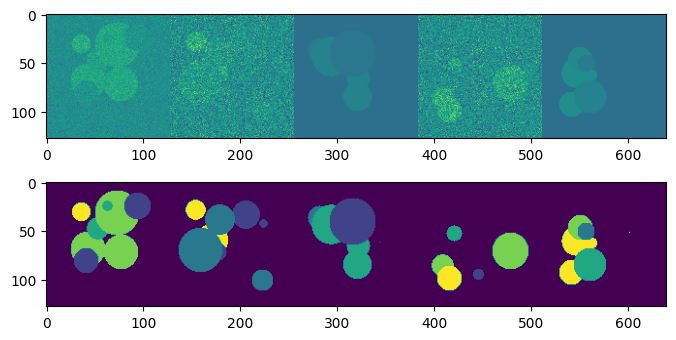

In [23]:
from monai.data import DataLoader
from monai.utils import first

loader = fixMe
batch = fixMe
print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

### Dataset caching

The following code creates a slow transform, wraps it in a Dataset and measures how much time it takes to iterate over it.
As the transform takes 1 second per data, iterating over the data takes about 5 seconds in total.


In [38]:
from monai.transforms import MapTransform
import time


class SlowSquare(MapTransform):
    def __call__(self, x):
        time.sleep(1.0)
        output = {key: x[key] ** 2 for key in self.keys}
        return output


transform = Compose([LoadImaged(keys="img"), SlowSquare(keys="img")])
square_dataset = Dataset(filenames, transform=transform)

%time list(square_dataset)

CPU times: total: 3.59 s
Wall time: 5.16 s


[{'img': metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          ...,
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
        

### Cache Dataset

1. Use a CacheDataset to load the data instead of the previous Dataset
2. Measure the time spent when creating the CacheDataset
3. Use timeit to measure the time to iterate over the cached dataset


In [37]:
from monai.data import CacheDataset
%time square_cached = fixMe
%timeit list(square_cached)

Loading dataset: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


CPU times: total: 3.67 s
Wall time: 5.17 s
7.89 µs ± 79.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Persistent Caching

1. Use a PersistentDataset to load the data instead of the previous Dataset
2. Measure the time spent when creating the PersistentDataset
3. Measure the time spent when first iterating over the PersistentDataset
4. Measure the time spent when iterating further the dataset
5. Print the content of the cache


In [40]:
from monai.data import PersistentDataset

%time square_persist =fixMe
%time list(square_persist)
%timeit list(square_persist)

from pathlib import Path
print("\n".join([str(p) for p in Path("my_cache").rglob("*")]))

CPU times: total: 0 ns
Wall time: 998 µs
CPU times: total: 3.58 s
Wall time: 5.23 s
10.7 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


1. Create a new PersistentDataset pointing to the same cache
2. Measure the instantiation and iteration

In [49]:
%time square_persist_2 = fixMe
%timeit list(square_persist_2)

CPU times: total: 0 ns
Wall time: 0 ns
10.6 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
